<div style="text-align: center;" >
<h1 style="margin-top: 0.2em; margin-bottom: 0.1em;">Assignment 3</h1>
<h4 style="margin-top: 0.7em; margin-bottom: 0.3em; font-style:italic">
Commit your solutions to our
<a href='https://classroom.github.com/a/w67qoR0U''>GitHub Classroom</a>
until June 24, 23:59</h4>
</div>
<br>

## Part 1
## Sentiment Evaluation of Twitter and YouTube Data

### Tasks

1. Install packages and load evaluation datasets with Google NLP scores
2. Run VADER over evaluation texts
3. Run BERT over evaluation texts
4. Evaluate against sentiment annotations and compare with Google NLP

### Install requirements.

The following cell contains all the necessary dependencies needed for this task. If you run the cell everything will be installed.

* [`vaderSentiment`](https://github.com/cjhutto/vaderSentiment) is a Python package for a Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text.
* [`transformers`](https://huggingface.co/) is a Python package for creating and working with transformers. [Here](https://huggingface.co/docs) is the documentation of `transformers`.
* [`torch`](https://pytorch.org/) is a Python machine learning framework. We need this here for `transformers` since this package uses internally `torch`. [Here](https://pytorch.org/docs/stable/index.html) is the documentation of `torch`.
* [`pandas`](https://pandas.pydata.org/docs/index.html) is a Python package for creating and working with tabular data. [Here](https://pandas.pydata.org/docs/reference/index.html) is the documentation of `pandas`.

In [152]:
# ! pip install vaderSentiment
# ! pip install transformers
# ! pip install torch
# ! pip install pandas
#!pip3 install emoji==0.6.0


You may need to restart the Kernel after installing the dependencies!

### Import requirements
The cell below imports all necessary dependancies. Make sure they are installed (see cell above).

In [153]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np
import re

### Exercise 1: Load evaluation datasets and Google NLP scores

#### 1.1 Load datasets
First read the Twitter and Youtube Comments CSV files (`Twitter-Sentiment.csv` and `YouTubeComments-Sentiment.csv`) and save them in a pandas Dataframe.

In [ ]:
# Loading Twitter Data
df_tw = pd.read_csv('data/Twitter-Sentiment.csv')
df_tw.head(5)

,label,text,googleScore
0,Positive,?RT @justinbiebcr: The bigger the better....if...,0.3
1,Positive,"Listening to the ""New Age"" station on @Slacker...",0.2
2,Neutral,I favorited a YouTube video -- Drake and Josh ...,0.0
3,Positive,i didnt mean knee high I ment in lengt it goes...,0.8
4,Neutral,I wana see the vid Kyan,0.0


In [ ]:
# Loading YouTube Data
df_yt = pd.read_csv('data/YouTubeComments-Sentiment.csv')
df_yt.head(5)

,label,text,googleScore
0,Negative,when the time comes for all to know it will be...,0.1
1,Neutral,@princessofportk The first are a pair of devil...,0.1
2,Neutral,I gotta feeling they partlishly took it off fo...,-0.3
3,Positive,"As we look at ways to be relevant, here is a g...",0.7
4,Neutral,"Not a lot of ""removing"" going on here... bucke...",-0.3


### Exercise 2: Run VADER over evaluation texts *(2 points)*

#### 2.1 Run VADER over the first tweet

In this task you should use VADER for sentiment analysis. For this we use the `vaderSentiment` package. You first have to instantiate a new `SentimentIntensityAnalyzer` and use the `polarity_scores` method of it for the analysis. Apply this for the first tweet. Is it a good classification?

[Here](https://github.com/cjhutto/vaderSentiment) under 'Code Examples' you can find some example code how to use this package.

In [ ]:
# Running VADER on one tweet
vaderAnalyzer=SentimentIntensityAnalyzer()
print(vaderAnalyzer.polarity_scores(df_tw["text"].iloc[0]))

{'neg': 0.0, 'neu': 0.853, 'pos': 0.147, 'compound': 0.2263}


#### 2.2 Run VADER over each text

Now use VADER for all the text data of the Twitter and the Youtube dataframe. Create a new column in the dataframes called `VADER_compound` where you save the `compound` result (look at the output dictonary of the `polarity_scores` method).

*Important: Make sure `compound` is a float*

In [ ]:
# Running VADER on all tweets and comments, storing classifications in new variable
compound=[]
for index,row in df_tw.iterrows():
    compound.append(float(vaderAnalyzer.polarity_scores(row["text"])["compound"]))
df_tw["VADER_compound"]=compound

compound=[]
for index,row in df_yt.iterrows():
    compound.append(float(vaderAnalyzer.polarity_scores(row["text"])["compound"]))
df_yt["VADER_compound"]=compound


#### 2.3 VADER as a classifier

To get the three Classes `Positive`, `Negative` and `Neutral` we use the compound score with the following thresholds:

* `compound > 0.5`: `"Positive"`
* `compound < -0.5`: `"Negative"`
* `else`: `"Neutral"`

Create a new column called `VADER_class` which contains the three computed classes.

In [ ]:
# Deriving classification labels

df_tw["VADER_class"]="Neutral"
df_tw.loc[df_tw['VADER_compound'] > 0.5, 'VADER_class'] = 'Positive'
df_tw.loc[df_tw['VADER_compound'] < -0.5, 'VADER_class'] = 'Negative'

df_yt["VADER_class"]="Neutral"
df_yt.loc[df_yt['VADER_compound'] > 0.5, 'VADER_class'] = 'Positive'
df_yt.loc[df_yt['VADER_compound'] < -0.5, 'VADER_class'] = 'Negative'

### Exercise 3: Use a BERT based model for sentiment analysis *(2 points)*

#### 3.1 BERT
BERT (Bidirectional Encoder Representation from Transformers) is a machine learning technique for natural language processing. There are already pretrained models available in the `transformers` package. You can look [here](https://huggingface.co/models?sort=downloads&search=sentiment) and choose a model for the next tasks. (We suggest [this](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest) (`"cardiffnlp/twitter-roberta-base-sentiment-latest"`) model, but you can use any available, just make sure it is suitable for sentiment analysis).

First create a `pipeline` where you set your model by the `model` keyword argument. You can then use this method to pass text which should be classified. [Here](https://huggingface.co/blog/sentiment-analysis-python#2-how-to-use-pre-trained-sentiment-analysis-models-with-python) is a tutorial how to use this.

As before save the classes in a new column 'BERT_class'. The call to your pipeline returns a dictionary where there is a key `label` which contains already the `positive`, `negative` or `neutral` class (Be aware that this is based on the model you choose, and might be different from the labels in the dataset. If that's the case you have to rename them to match the target labels).

***Hint: The classification of the entire sample can take a couple of minutes. Make sure to save the labeled dataset in a csv file so that you don't need to rerun the classification the next time you run your notebook.***

In [ ]:
# Hint -> loading roberta as a pipline
# BERT finetuned for Twitter data
tw_sentiment_pipeline = pipeline(model="cardiffnlp/twitter-roberta-base-sentiment-latest", tokenizer="cardiffnlp/twitter-roberta-base-sentiment-latest")

# BERT finetuned for YouTube
yt_sentiment_pipeline= pipeline(model="rahulk98/bert-finetuned-youtube_sentiment_analysis", tokenizer="rahulk98/bert-finetuned-youtube_sentiment_analysis")

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0
Device set to use cuda:0


In [ ]:
# Using pipelines for classification
pipeline_class=[]
for index,row in df_tw.iterrows():
    pipeline_class.append(tw_sentiment_pipeline(row["text"])[0]["label"].capitalize())

df_tw["BERT_class"]=pipeline_class

pipeline_class=[]
for index,row in df_yt.iterrows():
    pipeline_class.append(yt_sentiment_pipeline(row["text"])[0]["label"].capitalize())

df_yt["BERT_class"]=pipeline_class

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


### Exercise 4: Evaluate against sentiment annotations and compare with Google NLP *(4 points)*

#### 4.1 Convert GoogleNLP scores to classes

As with VADER and BERT, compute classes from the GoogleNLP score, which is given in the column `googleScore`. For this use following thresholds:

* `googleScore > 0.3`: `"Positive"`
* `googleScore < -0.3`: `"Negative"`
* `else`: `"Neutral"`

Save the classes in a new column named `GoogleNLP_class`.


In [ ]:
# Deriving NLP classification labels

df_tw["GoogleNLP_class"]="Neutral"
df_tw.loc[df_tw['googleScore'] > 0.3, 'GoogleNLP_class'] = 'Positive'
df_tw.loc[df_tw['googleScore'] < -0.3, 'GoogleNLP_class'] = 'Negative'

df_yt["GoogleNLP_class"]="Neutral"
df_yt.loc[df_yt['googleScore'] > 0.3, 'GoogleNLP_class'] = 'Positive'
df_yt.loc[df_yt['googleScore'] < -0.3, 'GoogleNLP_class'] = 'Negative'

In [ ]:
# Saving labeled data
df_yt.to_csv("data/youtube_labeled", index=False)
df_tw.to_csv("data/twitter_labeled", index=False)

In [ ]:
# Re-reading labeled data
df_yt=pd.read_csv("data/youtube_labeled")
df_tw=pd.read_csv("data/twitter_labeled")

#### 4.2 Evaluate on Twitter

First, let's calculate the accuracy for all three classifiers on the Twitter and Youtube data, print the results.

In [ ]:
# Accuracy scores
def accuracy(data, pred_label):
    acc=accuracy_score(y_true=data["label"], y_pred=data[pred_label])
    return acc


acc_yt_VADER = accuracy(df_yt, "VADER_class")
acc_tw_VADER = accuracy(df_tw, "VADER_class")
acc_overall_VADER = accuracy(pd.concat([df_yt, df_tw], ignore_index=True), "VADER_class")

acc_yt_BERT = accuracy(df_yt, "BERT_class")
acc_tw_BERT = accuracy(df_tw, "BERT_class")
acc_overall_BERT = accuracy(pd.concat([df_yt, df_tw], ignore_index=True), "BERT_class")

acc_yt_NLP = accuracy(df_yt, "GoogleNLP_class")
acc_tw_NLP = accuracy(df_tw, "GoogleNLP_class")
acc_overall_NLP = accuracy(pd.concat([df_yt, df_tw], ignore_index=True), "GoogleNLP_class")


print("Accuracy of VADER:")
print(f"YouTube: {acc_yt_VADER:.3}")
print(f"Twitter: {acc_tw_VADER:.3}")
print(f"Overall: {acc_overall_VADER:.3}")
print("\n")

print("Accuracy of BERT:")
print(f"YouTube: {acc_yt_BERT:.3}")
print(f"Twitter: {acc_tw_BERT:.3}")
print(f"Overall: {acc_overall_BERT:.3}")
print("\n")

print("Accuracy of GoogleNLP:")
print(f"YouTube: {acc_yt_NLP:.3}")
print(f"Twitter: {acc_tw_NLP:.3}")
print(f"Overall: {acc_overall_NLP:.3}")






Accuracy of VADER:
YouTube: 0.659
Twitter: 0.686
Overall: 0.674


Accuracy of BERT:
YouTube: 0.705
Twitter: 0.635
Overall: 0.666


Accuracy of GoogleNLP:
YouTube: 0.66
Twitter: 0.671
Overall: 0.666


Next calculate the precision of the `"Positive"` class for the Twitter and Youtube data.
This is calculated as follows:
$
\begin{align}
    precision = \frac{TP}{TP + FP}
\end{align}
$
*Note: Here the Positive samples are the one with the class-label `"Positive"`*

In [ ]:
# Precision scores
def precision(data, pred_label, class_label="Positive"):
    precisions=precision_score(y_true=data["label"], y_pred=data[pred_label], average=None)
    labels = sorted(data["label"].unique())
    positive_index = labels.index(class_label)
    return precisions[positive_index]

prec_pos_yt_VADER=precision(df_yt, "VADER_class")
prec_pos_tw_VADER=precision(df_tw, "VADER_class")
prec_pos_overall_VADER=precision(pd.concat([df_yt, df_tw], ignore_index=True), "VADER_class")

prec_pos_yt_BERT=precision(df_yt, "BERT_class")
prec_pos_tw_BERT=precision(df_tw, "BERT_class")
prec_pos_overall_BERT=precision(pd.concat([df_yt, df_tw], ignore_index=True), "BERT_class")

prec_pos_yt_NLP=precision(df_yt, "GoogleNLP_class")
prec_pos_tw_NLP=precision(df_tw, "GoogleNLP_class")
prec_pos_overall_NLP=precision(pd.concat([df_yt, df_tw], ignore_index=True), "GoogleNLP_class")

print("Precision of Positive Class: \n")

print("VADER:")
print(f"YouTube: {prec_pos_yt_VADER:.3}")
print(f"Twitter: {prec_pos_tw_VADER:.3}")
print(f"Overall: {prec_pos_overall_VADER:.3}")
print("\n")

print("BERT:")
print(f"YouTube: {prec_pos_yt_BERT:.3}")
print(f"Twitter: {prec_pos_tw_BERT:.3}")
print(f"Overall: {prec_pos_overall_BERT:.3}")
print("\n")

print("GoogleNLP:")
print(f"YouTube: {prec_pos_yt_NLP:.3}")
print(f"Twitter: {prec_pos_tw_NLP:.3}")
print(f"Overall: {prec_pos_overall_NLP:.3}")



Precision of Positive Class: 

VADER:
YouTube: 0.72
Twitter: 0.356
Overall: 0.543


BERT:
YouTube: 0.735
Twitter: 0.358
Overall: 0.55


GoogleNLP:
YouTube: 0.772
Twitter: 0.335
Overall: 0.574


Now calculate the recall score. This is done by:
$
\begin{align}
    recall = \frac{TP}{TP + FN}
\end{align}
$
*Note: Here the Positive samples are the one with the the class-label `"Positive"`*

In [ ]:
# Recall scores

def recall(data, pred_label, class_label="Positive"):
    recall=recall_score(y_true=data["label"], y_pred=data[pred_label], average=None)
    labels = sorted(data["label"].unique())
    positive_index = labels.index(class_label)
    return recall[positive_index]

recall_pos_yt_VADER=recall(df_yt, "VADER_class")
recall_pos_tw_VADER=recall(df_tw, "VADER_class")
recall_pos_overall_VADER=recall(pd.concat([df_yt, df_tw], ignore_index=True), "VADER_class")

recall_pos_yt_BERT=recall(df_yt, "BERT_class")
recall_pos_tw_BERT=recall(df_tw, "BERT_class")
recall_pos_overall_BERT=recall(pd.concat([df_yt, df_tw], ignore_index=True), "BERT_class")

recall_pos_yt_NLP=recall(df_yt, "GoogleNLP_class")
recall_pos_tw_NLP=recall(df_tw, "GoogleNLP_class")
recall_pos_overall_NLP=recall(pd.concat([df_yt, df_tw], ignore_index=True), "GoogleNLP_class")

print("Recall of Positive Class:\n")
print("VADER:")
print(f"YouTube: {recall_pos_yt_VADER:.3}")
print(f"Twitter: {recall_pos_tw_VADER:.3}")
print(f"Overall: {recall_pos_overall_VADER:.3}")
print("\n")

print("BERT:")
print(f"YouTube: {recall_pos_yt_BERT:.3}")
print(f"Twitter: {recall_pos_tw_BERT:.3}")
print(f"Overall: {recall_pos_overall_BERT:.3}")
print("\n")

print("GoogleNLP:")
print(f"YouTube: {recall_pos_yt_NLP:.3}")
print(f"Twitter: {recall_pos_tw_NLP:.3}")
print(f"Overall: {recall_pos_overall_NLP:.3}")


Recall of Positive Class:

VADER:
YouTube: 0.695
Twitter: 0.727
Overall: 0.705


BERT:
YouTube: 0.874
Twitter: 0.915
Overall: 0.886


GoogleNLP:
YouTube: 0.696
Twitter: 0.559
Overall: 0.654


Calculate the Recall and the Precision score now also for the negative class.

The Precision is calculated as:
$
\begin{align}
    precision = \frac{TP}{TP + FP}
\end{align}
$
*Note: Here the Positive samples are the one with the the class-label `"Negative"`*

And the Recall is calculated as:
$
\begin{align}
    recall = \frac{TP}{TP + FN}
\end{align}
$
*Note: Here the Positive samples are the one with the the class-label `"Negative"`*

In [ ]:
# Precision scores for negative class

def precision(data, pred_label, class_label="Negative"):
    precisions=precision_score(y_true=data["label"], y_pred=data[pred_label], average=None)
    labels = sorted(data["label"].unique())
    positive_index = labels.index(class_label)
    return precisions[positive_index]

prec_neg_yt_VADER=precision(df_yt, "VADER_class")
prec_neg_tw_VADER=precision(df_tw, "VADER_class")
prec_neg_overall_VADER=precision(pd.concat([df_yt, df_tw], ignore_index=True), "VADER_class")

prec_neg_yt_BERT=precision(df_yt, "BERT_class")
prec_neg_tw_BERT=precision(df_tw, "BERT_class")
prec_neg_overall_BERT=precision(pd.concat([df_yt, df_tw], ignore_index=True), "BERT_class")

prec_neg_yt_NLP=precision(df_yt, "GoogleNLP_class")
prec_neg_tw_NLP=precision(df_tw, "GoogleNLP_class")
prec_neg_overall_NLP=precision(pd.concat([df_yt, df_tw], ignore_index=True), "GoogleNLP_class")

print("Precision of Negative Class: \n")

print("VADER:")
print(f"YouTube: {prec_neg_yt_VADER:.3}")
print(f"Twitter: {prec_neg_tw_VADER:.3}")
print(f"Overall: {prec_neg_overall_VADER:.3}")
print("\n")

print("BERT:")
print(f"YouTube: {prec_neg_yt_BERT:.3}")
print(f"Twitter: {prec_neg_tw_BERT:.3}")
print(f"Overall: {prec_neg_overall_BERT:.3}")
print("\n")

print("GoogleNLP:")
print(f"YouTube: {prec_neg_yt_NLP:.3}")
print(f"Twitter: {prec_neg_tw_NLP:.3}")
print(f"Overall: {prec_neg_overall_NLP:.3}")

Precision of Negative Class: 

VADER:
YouTube: 0.613
Twitter: 0.399
Overall: 0.502


BERT:
YouTube: 0.557
Twitter: 0.382
Overall: 0.459


GoogleNLP:
YouTube: 0.566
Twitter: 0.34
Overall: 0.453


In [ ]:
# Recall scores for negative class

def recall(data, pred_label, class_label="Negative"):
    recall=recall_score(y_true=data["label"], y_pred=data[pred_label], average=None)
    labels = sorted(data["label"].unique())
    positive_index = labels.index(class_label)
    return recall[positive_index]

recall_neg_yt_VADER=recall(df_yt, "VADER_class")
recall_neg_tw_VADER=recall(df_tw, "VADER_class")
recall_neg_overall_VADER=recall(pd.concat([df_yt, df_tw], ignore_index=True), "VADER_class")

recall_neg_yt_BERT=recall(df_yt, "BERT_class")
recall_neg_tw_BERT=recall(df_tw, "BERT_class")
recall_neg_overall_BERT=recall(pd.concat([df_yt, df_tw], ignore_index=True), "BERT_class")

recall_neg_yt_NLP=recall(df_yt, "GoogleNLP_class")
recall_neg_tw_NLP=recall(df_tw, "GoogleNLP_class")
recall_neg_overall_NLP=recall(pd.concat([df_yt, df_tw], ignore_index=True), "GoogleNLP_class")

print("Recall of Negative Class:\n")
print("VADER:")
print(f"YouTube: {recall_neg_yt_VADER:.3}")
print(f"Twitter: {recall_neg_tw_VADER:.3}")
print(f"Overall: {recall_neg_overall_VADER:.3}")
print("\n")

print("BERT:")
print(f"YouTube: {recall_neg_yt_BERT:.3}")
print(f"Twitter: {recall_neg_tw_BERT:.3}")
print(f"Overall: {recall_neg_overall_BERT:.3}")
print("\n")

print("GoogleNLP:")
print(f"YouTube: {recall_neg_yt_NLP:.3}")
print(f"Twitter: {recall_neg_tw_NLP:.3}")
print(f"Overall: {recall_neg_overall_NLP:.3}")

Recall of Negative Class:

VADER:
YouTube: 0.36
Twitter: 0.36
Overall: 0.36


BERT:
YouTube: 0.659
Twitter: 0.819
Overall: 0.725


GoogleNLP:
YouTube: 0.399
Twitter: 0.336
Overall: 0.373


Last, calculate the [F1 score](https://towardsdatascience.com/the-f1-score-bec2bbc38aa6) of the positive and negative class for each classifier and dataset. The F1 score is calculated as:

$
\begin{align}
    F_1 = 2 * \frac{precision * recall}{precision + recall}
\end{align}
$

In [ ]:
# F1 scores 
def f1(precision, recall):
    f1=2*((precision*recall)/(precision+recall))
    return f1


f1_pos_yt_VADER=f1(precision=prec_pos_yt_VADER, recall=recall_pos_yt_VADER)
f1_pos_tw_VADER=f1(precision=prec_pos_tw_VADER, recall=recall_pos_tw_VADER)
f1_pos_overall_VADER=f1(precision=prec_pos_overall_VADER, recall=recall_pos_overall_VADER)

f1_pos_yt_BERT=f1(precision=prec_pos_yt_BERT, recall=recall_pos_yt_BERT)
f1_pos_tw_BERT=f1(precision=prec_pos_tw_BERT, recall=recall_pos_tw_BERT)
f1_pos_overall_BERT=f1(precision=prec_pos_overall_BERT, recall=recall_pos_overall_BERT)

f1_pos_yt_NLP=f1(precision=prec_pos_yt_NLP, recall=recall_pos_yt_NLP)
f1_pos_tw_NLP=f1(precision=prec_pos_tw_NLP, recall=recall_pos_tw_NLP)
f1_pos_overall_NLP=f1(precision=prec_pos_overall_NLP, recall=recall_pos_overall_NLP)

print("F1-Scores of Positive Class:\n")
print("VADER:")
print(f"YouTube: {f1_pos_yt_VADER:.3}")
print(f"Twitter: {f1_pos_tw_VADER:.3}")
print(f"Overall: {f1_pos_overall_VADER:.3}")
print("\n")

print("BERT:")
print(f"YouTube: {f1_pos_yt_BERT:.3}")
print(f"Twitter: {f1_pos_tw_BERT:.3}")
print(f"Overall: {f1_pos_overall_BERT:.3}")
print("\n")

print("GoogleNLP:")
print(f"YouTube: {f1_pos_yt_NLP:.3}")
print(f"Twitter: {f1_pos_tw_NLP:.3}")
print(f"Overall: {f1_pos_overall_NLP:.3}")

F1-Scores of Positive Class:

VADER:
YouTube: 0.707
Twitter: 0.478
Overall: 0.613


BERT:
YouTube: 0.798
Twitter: 0.514
Overall: 0.679


GoogleNLP:
YouTube: 0.732
Twitter: 0.419
Overall: 0.611


In [ ]:
# F1 scores for negative class

def f1(precision, recall):
    f1=2*((precision*recall)/(precision+recall))
    return f1


f1_neg_yt_VADER=f1(precision=prec_neg_yt_VADER, recall=recall_neg_yt_VADER)
f1_neg_tw_VADER=f1(precision=prec_neg_tw_VADER, recall=recall_neg_tw_VADER)
f1_neg_overall_VADER=f1(precision=prec_neg_overall_VADER, recall=recall_neg_overall_VADER)

f1_neg_yt_BERT=f1(precision=prec_neg_yt_BERT, recall=recall_neg_yt_BERT)
f1_neg_tw_BERT=f1(precision=prec_neg_tw_BERT, recall=recall_neg_tw_BERT)
f1_neg_overall_BERT=f1(precision=prec_neg_overall_BERT, recall=recall_neg_overall_BERT)

f1_neg_yt_NLP=f1(precision=prec_neg_yt_NLP, recall=recall_neg_yt_NLP)
f1_neg_tw_NLP=f1(precision=prec_neg_tw_NLP, recall=recall_neg_tw_NLP)
f1_neg_overall_NLP=f1(precision=prec_neg_overall_NLP, recall=recall_neg_overall_NLP)

print("F1-Scores of Negative Class:\n")
print("VADER:")
print(f"YouTube: {f1_neg_yt_VADER:.3}")
print(f"Twitter: {f1_neg_tw_VADER:.3}")
print(f"Overall: {f1_neg_overall_VADER:.3}")
print("\n")

print("BERT:")
print(f"YouTube: {f1_neg_yt_BERT:.3}")
print(f"Twitter: {f1_neg_tw_BERT:.3}")
print(f"Overall: {f1_neg_overall_BERT:.3}")
print("\n")

print("GoogleNLP:")
print(f"YouTube: {f1_neg_yt_NLP:.3}")
print(f"Twitter: {f1_neg_tw_NLP:.3}")
print(f"Overall: {f1_neg_overall_NLP:.3}")

F1-Scores of Negative Class:

VADER:
YouTube: 0.454
Twitter: 0.378
Overall: 0.419


BERT:
YouTube: 0.603
Twitter: 0.521
Overall: 0.562


GoogleNLP:
YouTube: 0.468
Twitter: 0.338
Overall: 0.409


### Exercise 5: Comparison *(2 points)*
* What was the best performing method for Youtube? Did that fit your expectations?
* What was the best performing method for Twitter? Did that fit your expectations?
* Do you observe any differences between prediction of positive and negative sentiment? What is the role of the imbalance between postive and negative classes in the calculation of accuracy?


In [ ]:
# Storing results in lists

accuracy_scores_yt=[acc_yt_BERT,acc_yt_VADER, acc_yt_NLP]
accuracy_score_tw=[acc_tw_BERT,acc_tw_VADER, acc_tw_NLP]
accuracy_score_overall=[acc_overall_BERT,acc_overall_VADER, acc_overall_NLP]

precision_pos_yt=[prec_pos_yt_BERT, prec_pos_yt_VADER, prec_pos_yt_NLP]
precision_pos_tw=[prec_pos_tw_BERT, prec_pos_tw_VADER, prec_pos_tw_NLP]
precision_pos_overall=[prec_pos_overall_BERT, prec_pos_overall_VADER, prec_pos_overall_NLP]

precision_neg_yt=[prec_neg_yt_BERT, prec_neg_yt_VADER, prec_neg_yt_NLP]
precision_neg_tw=[prec_neg_tw_BERT, prec_neg_tw_VADER, prec_neg_tw_NLP]
precision_neg_overall=[prec_neg_overall_BERT, prec_neg_overall_VADER, prec_neg_overall_NLP]

recall_pos_yt=[recall_pos_yt_BERT, recall_pos_yt_VADER, recall_pos_yt_NLP]
recall_pos_tw=[recall_pos_tw_BERT, recall_pos_tw_VADER, recall_pos_tw_NLP]
recall_pos_overall=[recall_pos_overall_BERT, recall_pos_overall_VADER, recall_pos_overall_NLP]

recall_neg_yt=[recall_neg_yt_BERT, recall_neg_yt_VADER, recall_neg_yt_NLP]
recall_neg_tw=[recall_neg_tw_BERT, recall_neg_tw_VADER, recall_neg_tw_NLP]
recall_neg_overall=[recall_neg_overall_BERT, recall_neg_overall_VADER, recall_neg_overall_NLP]

f1_pos_yt=[f1_pos_yt_BERT, f1_pos_yt_VADER, f1_pos_yt_NLP]
f1_pos_tw=[f1_pos_tw_BERT, f1_pos_tw_VADER, f1_pos_tw_NLP]
f1_pos_overall=[f1_pos_overall_BERT, f1_pos_overall_VADER, f1_pos_overall_NLP]

f1_neg_yt=[f1_neg_yt_BERT, f1_neg_yt_VADER, f1_neg_yt_NLP]
f1_neg_tw=[f1_neg_tw_BERT, f1_neg_tw_VADER, f1_neg_tw_NLP]
f1_neg_overall=[f1_neg_overall_BERT, f1_neg_overall_VADER, f1_neg_overall_NLP]


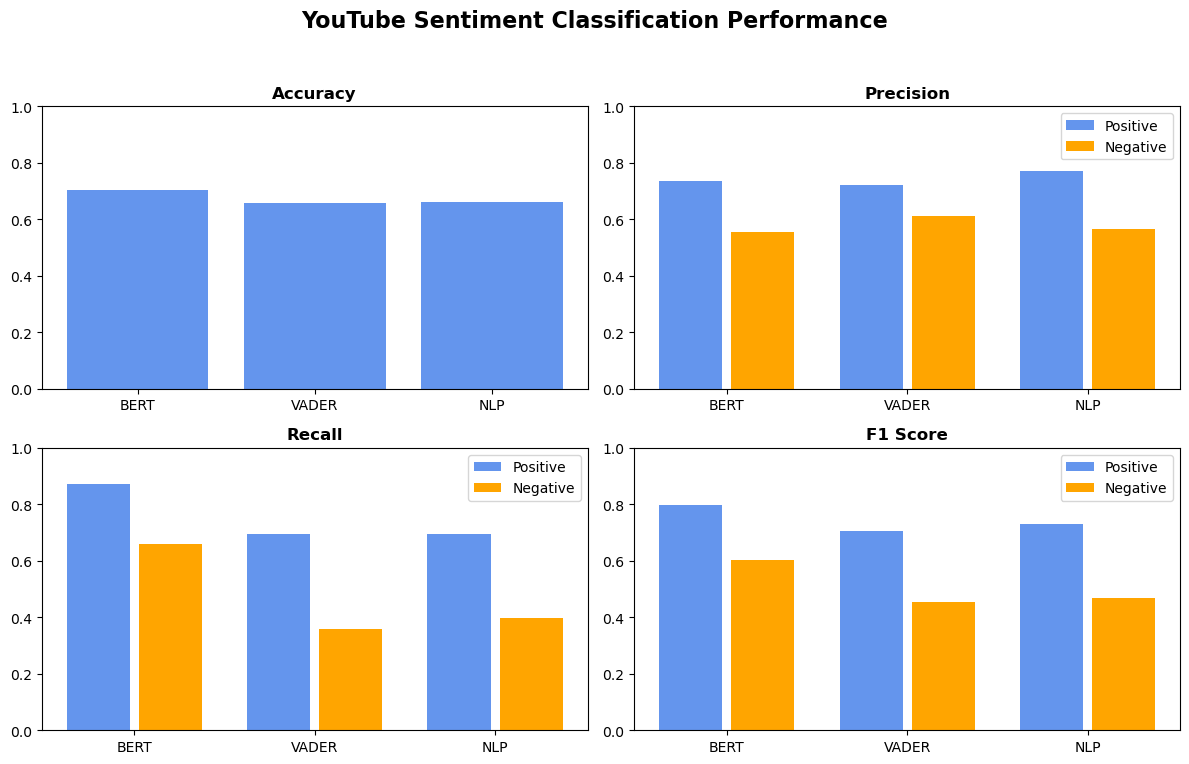

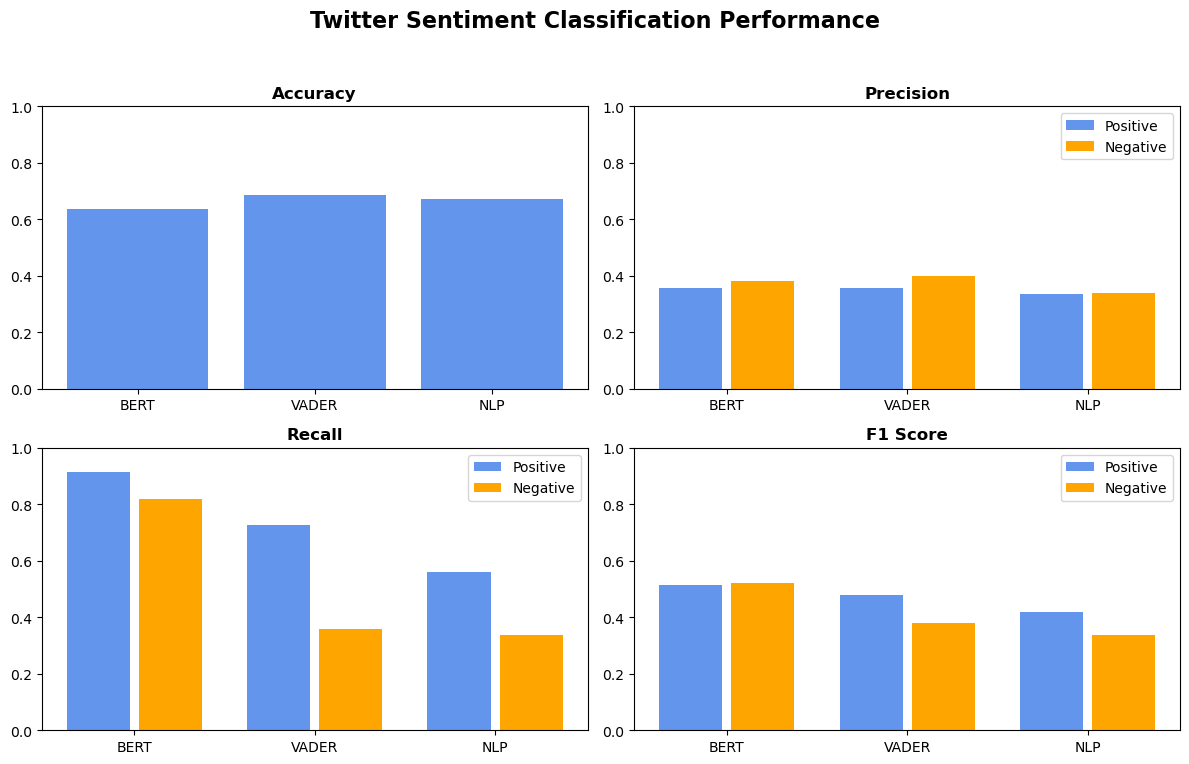

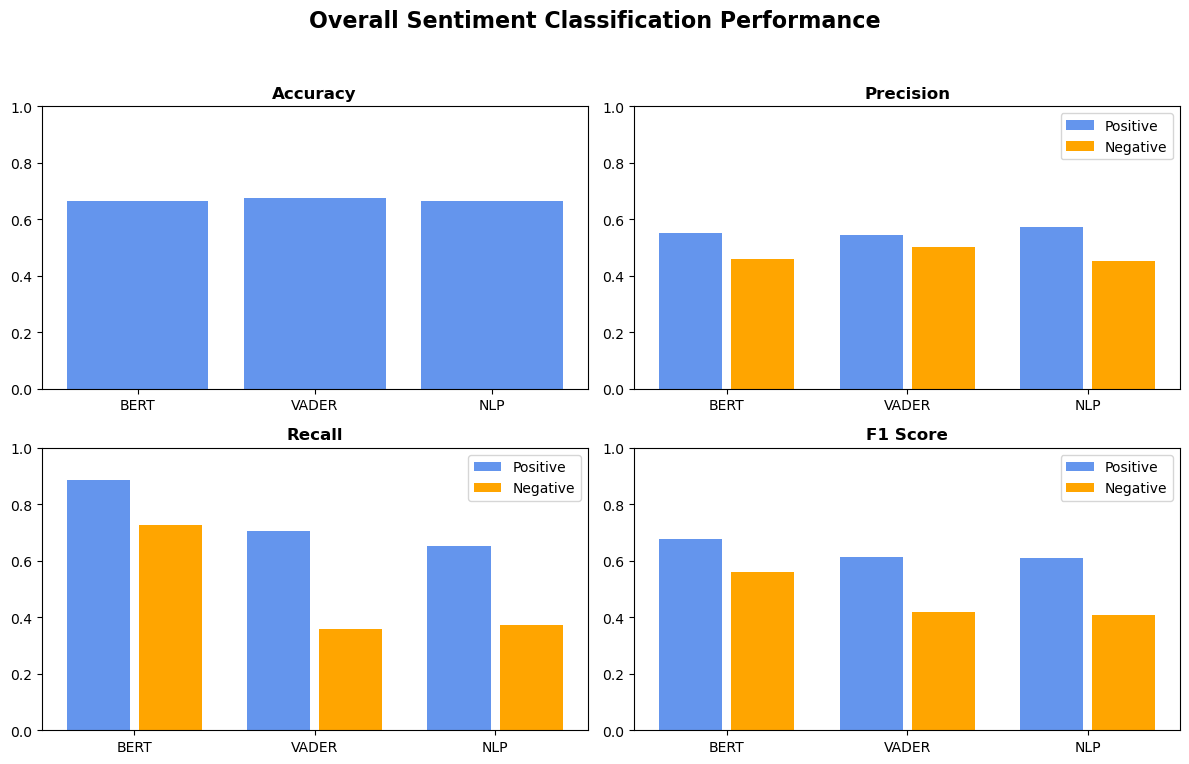

In [ ]:
# Visualization

models = ['BERT', 'VADER', 'NLP']
x = np.arange(len(models))  # the label locations
width = 0.35  # width of the bars

def plot_metrics(title_prefix, accuracy, prec_pos, prec_neg, recall_pos, recall_neg, f1_pos, f1_neg, gap=0.05):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle(f"{title_prefix} Sentiment Classification Performance", fontsize=16, fontweight='bold')

    # Accuracy
    axs[0, 0].bar(x, accuracy, color='cornflowerblue')
    axs[0, 0].set_title("Accuracy", fontweight="bold")
    axs[0, 0].set_xticks(x)
    axs[0, 0].set_xticklabels(models)
    axs[0, 0].set_ylim(0, 1)

    # Precision (positive vs. negative)
    axs[0, 1].bar(x - width/2 - gap/2, prec_pos, width, label='Positive', color='cornflowerblue')
    axs[0, 1].bar(x + width/2 + gap/2, prec_neg, width, label='Negative', color='orange')
    axs[0, 1].set_title("Precision", fontweight="bold")
    axs[0, 1].set_xticks(x)
    axs[0, 1].set_xticklabels(models)
    axs[0, 1].legend()
    axs[0, 1].set_ylim(0, 1)

    # Recall (positive vs. negative)
    axs[1, 0].bar(x - width/2 - gap/2, recall_pos, width, label='Positive', color='cornflowerblue')
    axs[1, 0].bar(x + width/2 + gap/2, recall_neg, width, label='Negative', color='orange')
    axs[1, 0].set_title("Recall", fontweight="bold")
    axs[1, 0].set_xticks(x)
    axs[1, 0].set_xticklabels(models)
    axs[1, 0].legend()
    axs[1, 0].set_ylim(0, 1)

    # F1 Score (positive vs. negative)
    axs[1, 1].bar(x - width/2 - gap/2, f1_pos, width, label='Positive', color='cornflowerblue')
    axs[1, 1].bar(x + width/2 + gap/2, f1_neg, width, label='Negative', color='orange')
    axs[1, 1].set_title("F1 Score", fontweight="bold")
    axs[1, 1].set_xticks(x)
    axs[1, 1].set_xticklabels(models)
    axs[1, 1].legend()
    axs[1, 1].set_ylim(0, 1)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Plot for YouTube
plot_metrics(
    title_prefix="YouTube",
    accuracy=accuracy_scores_yt,
    prec_pos=precision_pos_yt,
    prec_neg=precision_neg_yt,
    recall_pos=recall_pos_yt,
    recall_neg=recall_neg_yt,
    f1_pos=f1_pos_yt,
    f1_neg=f1_neg_yt
)

# Plot for Twitter
plot_metrics(
    title_prefix="Twitter",
    accuracy=accuracy_score_tw,
    prec_pos=precision_pos_tw,
    prec_neg=precision_neg_tw,
    recall_pos=recall_pos_tw,
    recall_neg=recall_neg_tw,
    f1_pos=f1_pos_tw,
    f1_neg=f1_neg_tw
)

plot_metrics(
    title_prefix="Overall",
    accuracy=accuracy_score_overall,
    prec_pos=precision_pos_overall,
    prec_neg=precision_neg_overall,
    recall_pos=recall_pos_overall,
    recall_neg=recall_neg_overall,
    f1_pos=f1_pos_overall,
    f1_neg=f1_neg_overall
)

### Evaluation:

For the YouTube data, BERT achieves the highest overall classification accuracy compared to the other models. While GoogleNLP shows better precision for the positive class and VADER performs better in precision for the negative class, BERT outperforms both in recall across both classes. As a result, BERT also attains the highest F1-score, indicating a well-balanced and effective classification.

When it comes to classifying tweets, VADER narrowly achieves the highest accuracy. Although VADER again holds a slight edge in precision for both classes, BERT leads in F1-score due to its strong recall performance on both positive and negative classes.

BERT’s overall strong results are not surprising, as both model versions were specifically trained on YouTube and Twitter datasets. The models likely perform well by capturing a broad range of positive cases, which can sometimes reduce precision slightly, allowing GoogleNLP and VADER to outperform BERT in precision in some cases.

In [ ]:
print((f"Number of Positive Comments: {(df_yt["label"] == "Positive").sum()}\nNumber of Negative Comments: {(df_yt["label"] == "Negative").sum()}\nNumber of Neutral Comments: {(df_yt["label"] == "Neutral").sum()}"))
print("\n")
print(f"Number of Positive Tweets: {(df_tw["label"] == "Positive").sum()}\nNumber of Negative Tweets: {(df_tw["label"] == "Negative").sum()}\nNumber of Neutral Tweets: {(df_tw["label"] == "Neutral").sum()}")

Number of Positive Comments: 1313
Number of Negative Comments: 536
Number of Neutral Comments: 1444


Number of Positive Tweets: 587
Number of Negative Tweets: 381
Number of Neutral Tweets: 3241


The imbalances between classification of positive/negative posts in both datasets could be due to general imbalances of positive vs. negative posts in social media and thus, training data (see above).

## Part 2 - Emotion Detection

### Exercise 6 *(4 points)*

In the following exercise you will use the emotion classification model [LEIA](https://huggingface.co/LEIA/LEIA-base) to classify the emotion of the sentences in the [enISEAR dataset](https://www.romanklinger.de/data-sets/). You can read more about the `LEIA-base` model in the [documentation](https://huggingface.co/LEIA/LEIA-base) and learn about the implementation details from this [paper](https://arxiv.org/abs/2304.10973).

#### 6.1 LEIA introduction
* Load the `LEIA-base` model and tokenize either as a [pipeline](https://huggingface.co/docs/transformers/main_classes/pipelines), or you can load the model and the tokenizer [directly](https://huggingface.co/docs/transformers/autoclass_tutorial) and implement the classification steps by yourself. LEIA only accepts sentences with up to 128 tokens. Make sure that your tokenizer [truncates](https://huggingface.co/docs/transformers/pad_truncation) longer sentences to this lenght to avoid errors.
* What are the possible labels the model can predict?
* Input the sentence `Today is a great day.` to the model, and predict the emotion of the sentence.

In [ ]:
# Importing LEIA pipeline
LEIA = pipeline(model="LEIA/LEIA-base", tokenizer="LEIA/LEIA-base", device=-1)
max_length=128

Device set to use cpu


In [175]:
labels = LEIA.model.config.id2label
print(labels)

{0: 'Sadness', 1: 'Affection', 2: 'Fear', 3: 'Happiness', 4: 'Anger'}


In [176]:
LEIA("Today is a great day.", max_length=max_length, truncation=True)

[{'label': 'Happiness', 'score': 0.799940288066864}]

#### 6.2 enISEAR dataset
* Load the enISEAR dataset.
* What are the possible labels in the dataset? (the `Prior_Emotion` column stores the actual ground-truth label)
* The last 7 columns store the number of annotators who chose the given emotion (e.g. if you have the value 3 in the column 'Anger', this means that 3 annotators believed that the sentence in the row expresses Anger). Create a new column `Annotator_Majority_Label`, which stores the emotion with the highest annotator score (i.e. the emotion the highest number of annotators chose for the given sentence).
* What percent of the sentences were correctly classified by the (majority vote of the) annotators?

In [ ]:
# Loading ISEAR data
df_isear = pd.read_csv('data/enISEAR.tsv', sep='\t')
df_isear.head(5)

,Sentence_id,Prior_Emotion,Sentence,Temporal_Distance,Intensity,Duration,Gender,City,Country,Worker_id,Time,Anger,Disgust,Fear,Guilt,Joy,Sadness,Shame
0,271,Fear,"I felt ... when my 2 year old broke her leg, a...",Y,Vi,Dom,Ml,Bristol,GBR,87,11/28/2018 00:58:52,0,0,0,1,0,3,1
1,597,Shame,I felt ... one Christmas as one of our patient...,Y,I,Dom,Fl,Dulwich,GBR,86,11/26/2018 06:52:02,1,0,0,4,0,0,0
2,282,Guilt,I felt ... because I could not help a friend w...,M,Mi,Dom,Fl,Linlithgow,GBR,83,11/21/2018 18:45:00,0,0,0,4,0,1,0
3,171,Disgust,I felt ... when I read that hunters had killed...,Y,Mi,H,Ml,Bristol,GBR,87,11/28/2018 00:55:11,3,0,0,0,0,2,0
4,509,Sadness,I felt ... when my Gran passed away.,Y,Vi,Dom,Fl,Stoke-on-trent,GBR,92,11/26/2018 09:23:38,0,0,0,0,0,5,0


In [178]:
df_isear["Prior_Emotion"].unique()

array(['Fear', 'Shame', 'Guilt', 'Disgust', 'Sadness', 'Anger', 'Joy'],
      dtype=object)

In [179]:
df_isear['Annotator_Majority_Label'] = df_isear.loc[:,"Anger":"Shame"].idxmax(axis=1)

print(f"{((df_isear['Prior_Emotion'] == df_isear['Annotator_Majority_Label']).sum()/len(df_isear))*100:.3}% of majority votes correspond to the correct emotion.")

79.6% of majority votes correspond to the correct emotion.


#### 6.3 Classification
* Drop the rows from the enISEAR dataset, where the `Prior_Emotion` is not one of `Fear`, `Sadness`, `Anger` or `Joy`
* Use `Leia` to classify the emotion of each remaining sentence in the dataset, and add a column `Leia_Label` to store the predicted classes
* Now remove `I felt ... ` (or variations of it) from the beginning of each sentence, and rerun the classfication. Store your results in a column named `Leia_Label_Clean`
* Where the model predicted `Happiness` or `Affection`, change the prediction to `Joy` to match the dataset's labels (for both columns -> `Leia_Label` and `Leia_Label_Clean`)

In [ ]:
# Classifying ISEAR sentences with LEIA

df_isear=df_isear[df_isear["Prior_Emotion"].isin(["Fear", "Anger", "Sadness", "Joy"])]

compound=[]
for index,row in df_isear.iterrows():
    compound.append(LEIA(row["Sentence"], max_length=max_length, truncation=True)[0]["label"])
df_isear["Leia_Label"]=compound

In [ ]:
# Classifying cleaned ISEAR sentences with LEIA

compound=[]
for index,row in df_isear.iterrows():
    compound.append(LEIA(re.sub(r"\bi (felt|feel)\b", "", row["Sentence"], flags=re.IGNORECASE), max_length=max_length, truncation=True)[0]["label"])
df_isear["Leia_Label_Clean"]=compound

In [ ]:
# Generalizing Happiness and Affection as Joy

df_isear['Leia_Label'] = df_isear['Leia_Label'].replace({
    'Happiness': 'Joy',
    'Affection': 'Joy'
})
df_isear['Leia_Label_Clean'] = df_isear['Leia_Label_Clean'].replace({
    'Happiness': 'Joy',
    'Affection': 'Joy'
})

In [ ]:
# Saving labeled data
df_isear.to_csv("data/isear_labeled", index=False)

In [ ]:
# Re-reading labeled data
df_isear=pd.read_csv("data/isear_labeled")

#### 6.4 Analysis
* Compare the performance of the two approaches, with each other, as well as with the performance of the human majority using the metrics introduced in part 1 (accuracy, precision, recall, f1 score) or other metrics you find interesting. Create informative visualizations to aid the comparison.
* Discuss your results.
* Are the models accurately predicting human emotions?
* Which approach seems to work better? Why?
* What kind of other/additional preprocessing could we perform to improve the model's predictions?

In [ ]:
# Accuracy
def accuracy(data, pred_label):
    acc=accuracy_score(y_true=data["Prior_Emotion"], y_pred=data[pred_label])
    return acc

acc_maj=accuracy(df_isear, "Annotator_Majority_Label")
acc_LEIA=accuracy(df_isear, "Leia_Label")
acc_LEIA_Clean=accuracy(df_isear, "Leia_Label_Clean")
acc=[acc_maj,acc_LEIA, acc_LEIA_Clean]

In [ ]:
# Precision
def precision(data, pred_label, class_label):
    precisions=precision_score(y_true=data["Prior_Emotion"], y_pred=data[pred_label], average=None)
    labels = sorted(set(data["Prior_Emotion"].unique()).union(set(data[pred_label].unique())))
    positive_index = labels.index(class_label)
    return precisions[positive_index]

prec_joy_maj=precision(df_isear,"Annotator_Majority_Label", "Joy")
prec_joy_LEIA=precision(df_isear,"Leia_Label", "Joy")
prec_joy_LEIA_Clean=precision(df_isear,"Leia_Label_Clean", "Joy")
prec_joy=[prec_joy_maj, prec_joy_LEIA, prec_joy_LEIA_Clean]
print(prec_joy)

prec_anger_maj=precision(df_isear,"Annotator_Majority_Label", "Anger")
prec_anger_LEIA=precision(df_isear,"Leia_Label", "Anger")
prec_anger_LEIA_Clean=precision(df_isear,"Leia_Label_Clean", "Anger")
prec_anger=[prec_anger_maj, prec_anger_LEIA, prec_anger_LEIA_Clean]
print(prec_anger)

prec_fear_maj=precision(df_isear,"Annotator_Majority_Label", "Fear")
prec_fear_LEIA=precision(df_isear,"Leia_Label", "Fear")
prec_fear_LEIA_Clean=precision(df_isear,"Leia_Label_Clean", "Fear")
prec_fear=[prec_fear_maj, prec_fear_LEIA, prec_fear_LEIA_Clean]
print(prec_fear)

prec_sadness_maj=precision(df_isear,"Annotator_Majority_Label", "Sadness")
prec_sadness_LEIA=precision(df_isear,"Leia_Label", "Sadness")
prec_sadness_LEIA_Clean=precision(df_isear,"Leia_Label_Clean", "Sadness")
prec_sadness=[prec_sadness_maj, prec_sadness_LEIA, prec_sadness_LEIA_Clean]
print(prec_sadness)

[0.9794520547945206, 0.9071428571428571, 0.9469026548672567]
[0.8840579710144928, 0.96, 0.8373983739837398]
[0.9398496240601504, 0.8071428571428572, 0.84375]
[0.916083916083916, 0.5852534562211982, 0.6009615384615384]


In [ ]:
# Recall
def recall(data, pred_label, class_label):
    recall=recall_score(y_true=data["Prior_Emotion"], y_pred=data[pred_label], average=None, zero_division=np.nan)
    labels = sorted(set(data["Prior_Emotion"].unique()).union(set(data[pred_label].unique())))
    positive_index = labels.index(class_label)
    return recall[positive_index]

recall_joy_maj=recall(df_isear,"Annotator_Majority_Label", "Joy")
recall_joy_LEIA=recall(df_isear,"Leia_Label", "Joy")
recall_joy_LEIA_Clean=recall(df_isear,"Leia_Label_Clean", "Joy")
recall_joy=[recall_joy_maj, recall_joy_LEIA, recall_joy_LEIA_Clean]
print(recall_joy)

recall_anger_maj=recall(df_isear,"Annotator_Majority_Label", "Anger")
recall_anger_LEIA=recall(df_isear,"Leia_Label", "Anger")
recall_anger_LEIA_Clean=recall(df_isear,"Leia_Label_Clean", "Anger")
recall_anger=[recall_anger_maj, recall_anger_LEIA, recall_anger_LEIA_Clean]
print(recall_anger)

recall_fear_maj=recall(df_isear,"Annotator_Majority_Label", "Fear")
recall_fear_LEIA=recall(df_isear,"Leia_Label", "Fear")
recall_fear_LEIA_Clean=recall(df_isear,"Leia_Label_Clean", "Fear")
recall_fear=[recall_fear_maj, recall_fear_LEIA, recall_fear_LEIA_Clean]
print(recall_fear)

recall_sadness_maj=recall(df_isear,"Annotator_Majority_Label", "Sadness")
recall_sadness_LEIA=recall(df_isear,"Leia_Label", "Sadness")
recall_sadness_LEIA_Clean=recall(df_isear,"Leia_Label_Clean", "Sadness")
recall_sadness=[recall_sadness_maj, recall_sadness_LEIA, recall_sadness_LEIA_Clean]
print(recall_sadness)

[1.0, 0.8881118881118881, 0.7482517482517482]
[0.8531468531468531, 0.5034965034965035, 0.7202797202797203]
[0.8741258741258742, 0.7902097902097902, 0.7552447552447552]
[0.916083916083916, 0.8881118881118881, 0.8741258741258742]


In [ ]:
# F1-scores
f1_joy = [
    f1(prec_joy_maj, recall_joy_maj),
    f1(prec_joy_LEIA, recall_joy_LEIA),
    f1(prec_joy_LEIA_Clean, recall_joy_LEIA_Clean)
]
print(f1_joy)

f1_anger = [
    f1(prec_anger_maj, recall_anger_maj),
    f1(prec_anger_LEIA, recall_anger_LEIA),
    f1(prec_anger_LEIA_Clean, recall_anger_LEIA_Clean)
]
print(f1_anger)

f1_fear = [
    f1(prec_fear_maj, recall_fear_maj),
    f1(prec_fear_LEIA, recall_fear_LEIA),
    f1(prec_fear_LEIA_Clean, recall_fear_LEIA_Clean)
]
print(f1_fear)

f1_sadness = [
    f1(prec_sadness_maj, recall_sadness_maj),
    f1(prec_sadness_LEIA, recall_sadness_LEIA),
    f1(prec_sadness_LEIA_Clean, recall_sadness_LEIA_Clean)
]
print(f1_sadness)

[0.9896193771626297, 0.8975265017667844, 0.8359375]
[0.8683274021352313, 0.6605504587155964, 0.7744360902255639]
[0.9057971014492754, 0.7985865724381626, 0.7970479704797048]
[0.916083916083916, 0.7055555555555556, 0.7122507122507122]


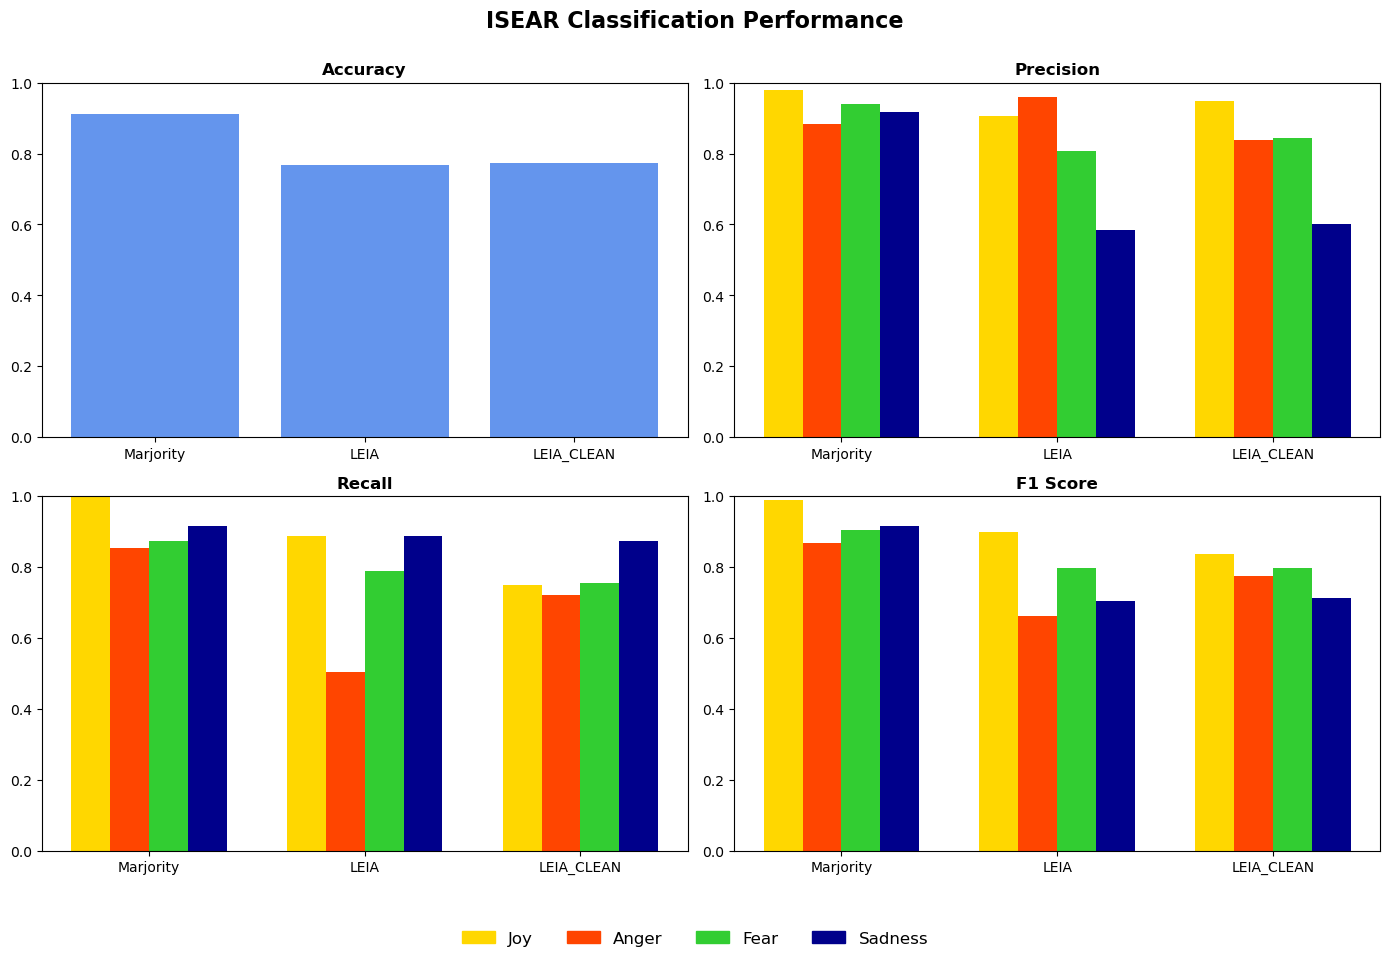

In [ ]:
# Visualization

emotions = ['Joy', 'Anger', 'Fear', 'Sadness']
x = np.arange(len(models))
width = 0.18

def plot_metrics_4_classes(title_prefix, accuracy, precision_list, recall_list, f1_list, models = ['Marjority', 'LEIA', 'LEIA_CLEAN']):
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f"{title_prefix} Classification Performance", fontsize=16, fontweight='bold', y=0.95)

    # Accuracy
    axs[0, 0].bar(x, accuracy, color='cornflowerblue')
    axs[0, 0].set_title("Accuracy", fontweight="bold")
    axs[0, 0].set_xticks(x)
    axs[0, 0].set_xticklabels(models)
    axs[0, 0].set_ylim(0, 1)

    colors = ['gold', 'orangered', 'limegreen', 'darkblue']

    def plot_grouped_bars(ax, metric_lists, metric_name):
        bars = []
        for i, emotion in enumerate(emotions):
            positions = x - 1.5*width + i*width
            bar = ax.bar(positions, metric_lists[i], width=width, label=emotion, color=colors[i])
            bars.append(bar)
        ax.set_title(metric_name, fontweight="bold")
        ax.set_xticks(x)
        ax.set_xticklabels(models)
        ax.set_ylim(0, 1)
        # No legend here!

    plot_grouped_bars(axs[0, 1], precision_list, "Precision")
    plot_grouped_bars(axs[1, 0], recall_list, "Recall")
    plot_grouped_bars(axs[1, 1], f1_list, "F1 Score")

    # Create one legend for the whole figure (using the bars from the last subplot)
    fig.legend(
        [plt.Rectangle((0,0),1,1,color=colors[i]) for i in range(len(emotions))],
        emotions,
        loc='lower center', ncol=4, fontsize='large', frameon=False
    )

    plt.tight_layout(rect=[0, 0.07, 1, 0.95])  # leave room at bottom for legend
    plt.show()


plot_metrics_4_classes(
    title_prefix="ISEAR",
    accuracy=acc,
    precision_list=[prec_joy, prec_anger, prec_fear, prec_sadness],
    recall_list=[recall_joy, recall_anger, recall_fear, recall_sadness],
    f1_list=[f1_joy, f1_anger, f1_fear, f1_sadness]
)

### Evaluation:

Human Majority Vote appears to be the best sentiment classifier. It generally outperforms both LEIA approaches in all four metrics with consistent performances in all four emotion classes, especially joy. Cleaning the statements does not seem to have a strong impact on LEIAs classification accuracy. At most, it resulted in somewhat more balanced precision/recall and F1-scores across classes. While LEIA (and LEIA_Clean) displays strong recall of Sadness (with a hard tradeoff in precision), the overalll F1-score aligns with human classification in that joy seems to be most straightforwardly identifiable. This could be because Anger, Fear, and Sadness all are negative emotions and thus, more easily confused with each other.

An additional approach to preparing data might be to remove more general stop words, especially those following ... (such as "when" or "because"). This might boil the sentences down to the most essential sentiment information.

### Exercise 7 *(6 points)*

#### 7.1 Data annotation
* In the following exercise you will need to test emotion detection methods on data from [Vent](https://www.vent.co/), a website where users talk about their feelings.
* On GitHub, in the `a03/data` folder you can find 2 files. First open `data_for_labeling.csv`. This file contains 100 texts. Import the data and sample 30 random texts. Remember to set a seed and save the sample to a separate csv. This is the sample, for which you are supposed to label the emotion in each sentence. Feel free to do this in the csv (i.e. in Excel). The possible classes are: 0 (Sadness), 1 (Affection), 2 (Fear), 3 (Happiness), 4 (Anger). ***Important: Make sure to upload the labeled data with your submission.***
* After you finished labeling the data load it as a pandas dataframe. Also load `data_with_labels.csv` as a dataframe, which contains the actual labels of the 100 rows of data.
* Merge the two dataframes (so that you end up with the 30 rows, you sampled. Including your labels and the ground truth), and rename the column containing your labels as `label_human`.
* Rename the class ids (0, 1, 2, ...) stored in the `label`, and `label_human` columns to the class names (Sadness, Affection, ...).

In [ ]:
# Reading/Sampling/Saving Data
df_for_labeling=pd.read_csv("data/data_for_labeling.csv")
df_for_labeling.reset_index(inplace=True)
df_for_labeling_sample=df_for_labeling.sample(n=30, random_state=42)
df_for_labeling_sample.to_csv("data/data_for_labeling_sample.csv", index=False)

In [ ]:
# Re-reading hand-labeled data
df_vent_sample_labled=pd.read_csv("data/data_sample_labeled.csv", sep=";")
df_vent=pd.read_csv("data/data_with_labels.csv")
df_vent.reset_index(inplace=True)

In [ ]:
# Merging, preparing labeled data on hand-labeled data
df_vent_sample=pd.merge(left=df_vent_sample_labled, right=df_vent, on="index", how="left").drop("text_y", axis=1)
df_vent_sample.rename(columns={'text_x': 'text'}, inplace=True)

df_vent_sample["label_human"] = df_vent_sample["label_human"].replace({
    0: "Sadness",
    1: "Affection",
    2: "Fear",
    3: "Happiness",
    4: "Anger"
})

df_vent_sample["label"] = df_vent_sample["label"].replace({
    0: "Sadness",
    1: "Affection",
    2: "Fear",
    3: "Happiness",
    4: "Anger"
})

#### 7.2 LEIA
* Use the [LEIA](https://huggingface.co/LEIA/LEIA-base) model introduced in the previous exercise to classify the sentences and store the results in a column named `label_leia`.

In [ ]:
# Applying LEIA for classification

compound=[]

for index,row in df_vent_sample.iterrows():
    compound.append(LEIA(row["text"])[0]["label"])

df_vent_sample["label_leia"]=compound

In [ ]:
# Saving LEIA labeled data
df_vent_sample.to_csv("data/data_sample_labeled.csv")

In [ ]:
# From here on everything is done in Google Collab:

#### 7.3 Open Models from the Hugging Face Model Hub

* In the following task, we are going to work with Llama, a Large Language Model provided by Meta. We want to use it to classify the same 30 texts as you and LEIA did already to compare sentiment classification performance.
* [Hugging Face](https://huggingface.co/) is a platform where different machine learning models are distributed. We are going to use the Llama Model via this page.
* Since language models can get quite big, it makes sense to use these with a GPU for faster loading and inference. Therefore, we need a provider of GPU access. Options are either [GoogleColab](https://colab.research.google.com) or [Kaggle](https://www.kaggle.com/).
* This guide is going to outline the use via Kaggle, but you are free to use other services for GPU access.



1) Create an account and sign into [Kaggle](https://www.kaggle.com/account/login)
2) Create an account and sign into [Hugging Face](https://huggingface.co/)
    * Here, you need to generate an [API Key on Hugging Face](https://huggingface.co/settings/tokens) in order to be able to access the models (see screenshot below)
    * Save the access token in a .txt file

3) We are going to use the Llama Model in Version 3.1 with 8 billion parameters. To do so, you need to request the access from Meta via the [models hugging face page](https://huggingface.co/meta-llama/Llama-3.1-8B-Instruct). On the linked page, you should find a box telling you that you need to request model access. To be granted access should happen within a couple of minutes.

4) To use the model, we now need to move to Kaggle. After you logged in, check out the sidebar on the left hand, where you can find a menu option `Code`. Select it and click on `+ New Notebook`. After the notebook got opened, navigate to the top left, select `File` and `Import Notebook`. Upload this notebook.
 * On Kaggle, you have 30h of GPU use per
 * To start GPU usage, navigate to the right. In the `Session options` under `Accelerator` you can use select a GPU to use. To save compute time, make sure to turn this usage off, after you are done (but be aware that turning on and off stops and restarts your session (kernel restart)).
 * To later download your notebook, again use `File` and `Download Notebook`.

6) Next, we need to install the hugging face package for python to be able to load the model. To get the access, we have to authenticate via the API key, we generated on Hugging Face.
* Code to install the packages is provided below.



In [ ]:
# #install packages

# !pip install huggingface_hub
# !pip install torch
# !pip install accelerate
# !pip install transformers
# !pip install -U bitsandbytes
# !pip install -U transformers

* Kaggle offers a way to load your API Key in a save way. To do so, navigate to the top and `Add-ons` where you select `Secrets`. In the panel, which opens on the right, you can add a new secret token. Name it i.e. 'Hugging Face' and enter your API key. Kaggle provides you the code snippet to load this token in the notebook. Depending on the name you assigned to the key, it should look like this:

In [ ]:
# load API key in a save way

from huggingface_hub import login
from getpass import getpass

# This is a cool way to enter the HF key in collab
token = getpass("Enter your Hugging Face token: ")
login(token)

Enter your Hugging Face token: ··········


* To log into Hugging Face from this Kaggle page, we use the log in client from the `huggingface_hub` package

7) The last thing is that we have to import the datasets, which we need to use. To do so, navigate to the right. In the section `Inputs`, you select `Upload` and `New Dataset`. Select the csv's you want to upload, assign a name and upload.
* To import the data, Kaggle offers an option to directly copy the file path to the clipbord (hover over the dataset's name and you see an option `copy file path` on the right hand side)


In [13]:
# imports

from transformers import pipeline
import os
import transformers
from transformers import (AutoModelForCausalLM,
                          AutoTokenizer,
                          BitsAndBytesConfig)
import torch
import pandas as pd
import bitsandbytes as bnb

In [3]:
# empty the memory and check if the GPU is available

torch.cuda.empty_cache()
torch.cuda.is_available()

True

In [41]:
# import data
from google.colab import files
# uploaded = files.upload()
df = pd.read_csv("data_with_labels.csv")

df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.head(2)

sents = df['text'].values

sample_text = sents[25]
sample_text

'Great now my head hurts too'

8. Now, we can finally load and use the model

In [ ]:
# specify the models name
model_id = "meta-llama/Meta-Llama-3.1-8B-Instruct"

# add the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id)

# quantization options to compress the model to that it fits with the memory
quantization_config = BitsAndBytesConfig(
    load_in_4bit = True,
    bnb_4bit_quant_type = 'nf4',
    bnb_4bit_use_double_quant = True,
    bnb_4bit_compute_dtype = torch.bfloat16
)

# load the model
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config = quantization_config # with quantization
)

# instantiate a pipeline
pipeline = transformers.pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    return_full_text=True
)


In [43]:
# here, we specify the input consisting of a system prompt (which gived the model general instructions on how to behave)
# some user prompts with assistant return which serve as examples
# and the final user input with the current text to classify into sentiments.



messages = [
    # system prompt
    {"role": "system", "content": """You are now Emotbot. Emotbot answers with only one of the following words: Sadness, Affection, Fear, Happiness, Anger.
                                    If Emotbot answers with anything else they have failed. Emotbot cannot fail. Emotbot will be provided with short pieces of text from the website 'Vent'.
                                    'Vent' is a website where users can share their feelings to an anonymous audience.
                                    When writing the 'Vent' text, the authors selected 1 of the following emotions to represent what they were feeling: 'Sadness', 'Affection', 'Fear', 'Happiness', or 'Anger'.
                                    Emotbot will read and analyse the text and predict which of the 5 feelings the author had selected."""},

    # example 1
    {"role": "user", "content": "I hate fuckin every single person on this fuckin planet. Someone kill me pls"},
    {"role": "assistant", "content": "Sadeness"},

    # example 2
    {"role": "user", "content": "Best day I have had in a long time :)"},
    {"role": "assistant", "content": "Happiness"},

    # example 3
    {"role": "user", "content": "boy I like called me princess He’s so precious"},
    {"role": "assistant", "content": "Affection"},

    # actual text to classify
    {"role": "user", "content": sample_text},

    # no assistant role

]



In [44]:
outputs = pipeline(
    messages,
    max_new_tokens=10,
)

print(outputs)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[{'generated_text': [{'role': 'system', 'content': "You are now Emotbot. Emotbot answers with only one of the following words: Sadness, Affection, Fear, Happiness, Anger. \n                                    If Emotbot answers with anything else they have failed. Emotbot cannot fail. Emotbot will be provided with short pieces of text from the website 'Vent'.\n                                    'Vent' is a website where users can share their feelings to an anonymous audience.\n                                    When writing the 'Vent' text, the authors selected 1 of the following emotions to represent what they were feeling: 'Sadness', 'Affection', 'Fear', 'Happiness', or 'Anger'.\n                                    Emotbot will read and analyse the text and predict which of the 5 feelings the author had selected."}, {'role': 'user', 'content': 'I hate fuckin every single person on this fuckin planet. Someone kill me pls'}, {'role': 'assistant', 'content': 'Sadeness'}, {'role': 'use

In [45]:
label = outputs[0]['generated_text'][-1]['content']
print(f"The predicted label for '{sample_text}' is: {label}")

The predicted label for 'Great now my head hurts too' is: Anger


In [ ]:
# Loading the Vent sample, uncomment the first line to upload data into collab

# uploaded = files.upload()
df_vent_sample= pd.read_csv("data_sample_labeled.csv", sep=";")

In [ ]:
# Iterating Llama classification over Vent sample
compound=[]

for index,row in df_vent_sample.iterrows():
  messages = [
    # system prompt
    {"role": "system", "content": """You are now Emotbot. Emotbot answers with only one of the following words: Sadness, Affection, Fear, Happiness, Anger.
                                    If Emotbot answers with anything else they have failed. Emotbot cannot fail. Emotbot will be provided with short pieces of text from the website 'Vent'.
                                    'Vent' is a website where users can share their feelings to an anonymous audience.
                                    When writing the 'Vent' text, the authors selected 1 of the following emotions to represent what they were feeling: 'Sadness', 'Affection', 'Fear', 'Happiness', or 'Anger'.
                                    Emotbot will read and analyse the text and predict which of the 5 feelings the author had selected."""},

    # example 1
    {"role": "user", "content": "I hate fuckin every single person on this fuckin planet. Someone kill me pls"},
    {"role": "assistant", "content": "Sadeness"},

    # example 2
    {"role": "user", "content": "Best day I have had in a long time :)"},
    {"role": "assistant", "content": "Happiness"},

    # example 3
    {"role": "user", "content": "boy I like called me princess He’s so precious"},
    {"role": "assistant", "content": "Affection"},

    # actual text to classify
    {"role": "user", "content": row["text"]},

    # no assistant role
    ]

  outputs = pipeline(
    messages,
    max_new_tokens=10,
    )

  compound.append(outputs[0]['generated_text'][-1]['content'])



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

In [ ]:
# Storing Llama classifications in Vent sample, saving as csv and downloading
df_vent_sample["label_llama"]=compound
df_vent_sample.to_csv('data_sample_labeled.csv', index=False)
files.download("data_sample_labeled.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Now, we're back in VS Code again.

#### 7.4 Comparison
* Compare the performance of the two models (Leia and LLama), with each other, as well as with the quality of your annotation using the metrics introduced in part 1 (accuracy, precision, recall, f1 score) or other metrics you find interesting. Create informative visualizations to aid the comparison.
* Discuss your results.
* Are the models accurately predicting human emotions?
* Which approach seems to work better? Why?

In [ ]:
# The order of variables is a bit off than when you would run the code from top to bottom in Google Collab, this is because I had to readjust some stuff above.
# The values of each classification variable however should be correct
df_vent_sample=pd.read_csv("data/data_sample_labeled.csv")
df_vent_sample.head(15)

,Unnamed: 0,index,text,label_human,label_llama,label,label_leia
0,0,83,I'm so busy this weekend that I have no time t...,Sadness,Sadness,Anger,Fear
1,1,53,I don't even know what I'm doing for my birthday.,Sadness,Sadness,Fear,Fear
2,2,70,I get to go home today and I get my new phone ...,Happiness,Happiness,Happiness,Happiness
3,3,45,This weekend is stressing me out. I have to be...,Fear,Fear,Fear,Fear
4,4,44,I feel weird and empty and sad and happy and w...,Sadness,Sadness,Fear,Fear
5,5,39,You get upset when your phone doesn't work and...,Affection,Affection,Affection,Anger
6,6,22,I hate boys as much as I love them. 😁😘,Anger,Anger,Affection,Affection
7,7,80,I've never been so tired that much😑😞,Sadness,Sadness,Anger,Anger
8,8,10,I tried not to care today and I almost didn't,Sadness,Sadness,Sadness,Sadness
9,9,0,I want you so bad. So bad. I miss you.,Affection,Affection,Sadness,Sadness


In [ ]:
# Generalizing Joy again

df_vent_sample['label_human'] = df_vent_sample['label_human'].replace({
    'Happiness': 'Joy',
    'Affection': 'Joy'
})
df_vent_sample['label_leia'] = df_vent_sample['label_leia'].replace({
    'Happiness': 'Joy',
    'Affection': 'Joy'
})

df_vent_sample['label_llama'] = df_vent_sample['label_llama'].replace({
    'Happiness': 'Joy',
    'Affection': 'Joy'
})
df_vent_sample['label'] = df_vent_sample['label'].replace({
    'Happiness': 'Joy',
    'Affection': 'Joy'
})

In [ ]:
# Accuracy
def accuracy(pred_label, data=df_vent_sample):
    acc=accuracy_score(y_true=data["label"], y_pred=data[pred_label])
    return acc

acc_human=accuracy("label_human")
acc_LEIA=accuracy("label_leia")
acc_LLAMA=accuracy("label_llama")
acc=[acc_human,acc_LEIA, acc_LLAMA]
print(acc)

[0.6, 0.8, 0.6333333333333333]


In [ ]:
# Precision
def precision(pred_label, class_label, data=df_vent_sample):
    labels = sorted(set(data["label"].unique()).union(set(data[pred_label].unique())))
    precisions = precision_score(
        y_true=data["label"],
        y_pred=data[pred_label],
        average=None,
        labels=labels
    )
    positive_index = labels.index(class_label)
    return precisions[positive_index]

# Example usage for the emotion "Joy"
prec_joy = [
    precision("label_human", "Joy"),
    precision("label_leia", "Joy"),
    precision("label_llama", "Joy"),
]
print("Precision for Joy:", prec_joy)

# Repeat for other emotions
prec_anger = [
    precision("label_human", "Anger"),
    precision("label_leia", "Anger"),
    precision("label_llama", "Anger"),
]
print("Precision for Anger:", prec_anger)

prec_fear = [
    precision("label_human", "Fear"),
    precision("label_leia", "Fear"),
    precision("label_llama", "Fear"),
]
print("Precision for Fear:", prec_fear)

prec_sadness = [
    precision("label_human", "Sadness"),
    precision("label_leia", "Sadness"),
    precision("label_llama", "Sadness"),
]
print("Precision for Sadness:", prec_sadness)

Precision for Joy: [0.6923076923076923, 1.0, 0.8181818181818182]
Precision for Anger: [0.6666666666666666, 0.6, 0.5]
Precision for Fear: [1.0, 0.75, 0.75]
Precision for Sadness: [0.36363636363636365, 0.75, 0.4444444444444444]


In [ ]:
# Recall

def recall(pred_label, class_label, data=df_vent_sample):
    labels = sorted(set(data["label"].unique()).union(set(data[pred_label].unique())))
    recalls = recall_score(
        y_true=data["label"],
        y_pred=data[pred_label],
        average=None,
        labels=labels,
        zero_division=np.nan
    )
    positive_index = labels.index(class_label)
    return recalls[positive_index]

# Recall for each emotion
recall_joy = [
    recall("label_human", "Joy"),
    recall("label_leia", "Joy"),
    recall("label_llama", "Joy"),
]
print("Recall for Joy:", recall_joy)

recall_anger = [
    recall("label_human", "Anger"),
    recall("label_leia", "Anger"),
    recall("label_llama", "Anger"),
]
print("Recall for Anger:", recall_anger)

recall_fear = [
    recall("label_human", "Fear"),
    recall("label_leia", "Fear"),
    recall("label_llama", "Fear"),
]
print("Recall for Fear:", recall_fear)

recall_sadness = [
    recall("label_human", "Sadness"),
    recall("label_leia", "Sadness"),
    recall("label_llama", "Sadness"),
]
print("Recall for Sadness:", recall_sadness)

Recall for Joy: [0.75, 0.75, 0.75]
Recall for Anger: [0.4, 0.6, 0.6]
Recall for Fear: [0.5, 1.0, 0.5]
Recall for Sadness: [0.5714285714285714, 0.8571428571428571, 0.5714285714285714]


In [ ]:
# F1
f1_joy = [
    f1(precision("label_human", "Joy"), recall("label_human", "Joy")),
    f1(precision("label_leia", "Joy"), recall("label_leia", "Joy")),
    f1(precision("label_llama", "Joy"), recall("label_llama", "Joy"))
]
print("F1 for Joy:", f1_joy)

# Anger
f1_anger = [
    f1(precision("label_human", "Anger"), recall("label_human", "Anger")),
    f1(precision("label_leia", "Anger"), recall("label_leia", "Anger")),
    f1(precision("label_llama", "Anger"), recall("label_llama", "Anger"))
]
print("F1 for Anger:", f1_anger)

# Fear
f1_fear = [
    f1(precision("label_human", "Fear"), recall("label_human", "Fear")),
    f1(precision("label_leia", "Fear"), recall("label_leia", "Fear")),
    f1(precision("label_llama", "Fear"), recall("label_llama", "Fear"))
]
print("F1 for Fear:", f1_fear)

# Sadness

f1_sadness = [
    f1(precision("label_human", "Sadness"), recall("label_human", "Sadness")),
    f1(precision("label_leia", "Sadness"), recall("label_leia", "Sadness")),
    f1(precision("label_llama", "Sadness"), recall("label_llama", "Sadness"))
]
print("F1 for Sadness:", f1_sadness)

F1 for Joy: [0.7199999999999999, 0.8571428571428571, 0.7826086956521738]
F1 for Anger: [0.5, 0.6, 0.5454545454545454]
F1 for Fear: [0.6666666666666666, 0.8571428571428571, 0.6]
F1 for Sadness: [0.4444444444444444, 0.7999999999999999, 0.5]


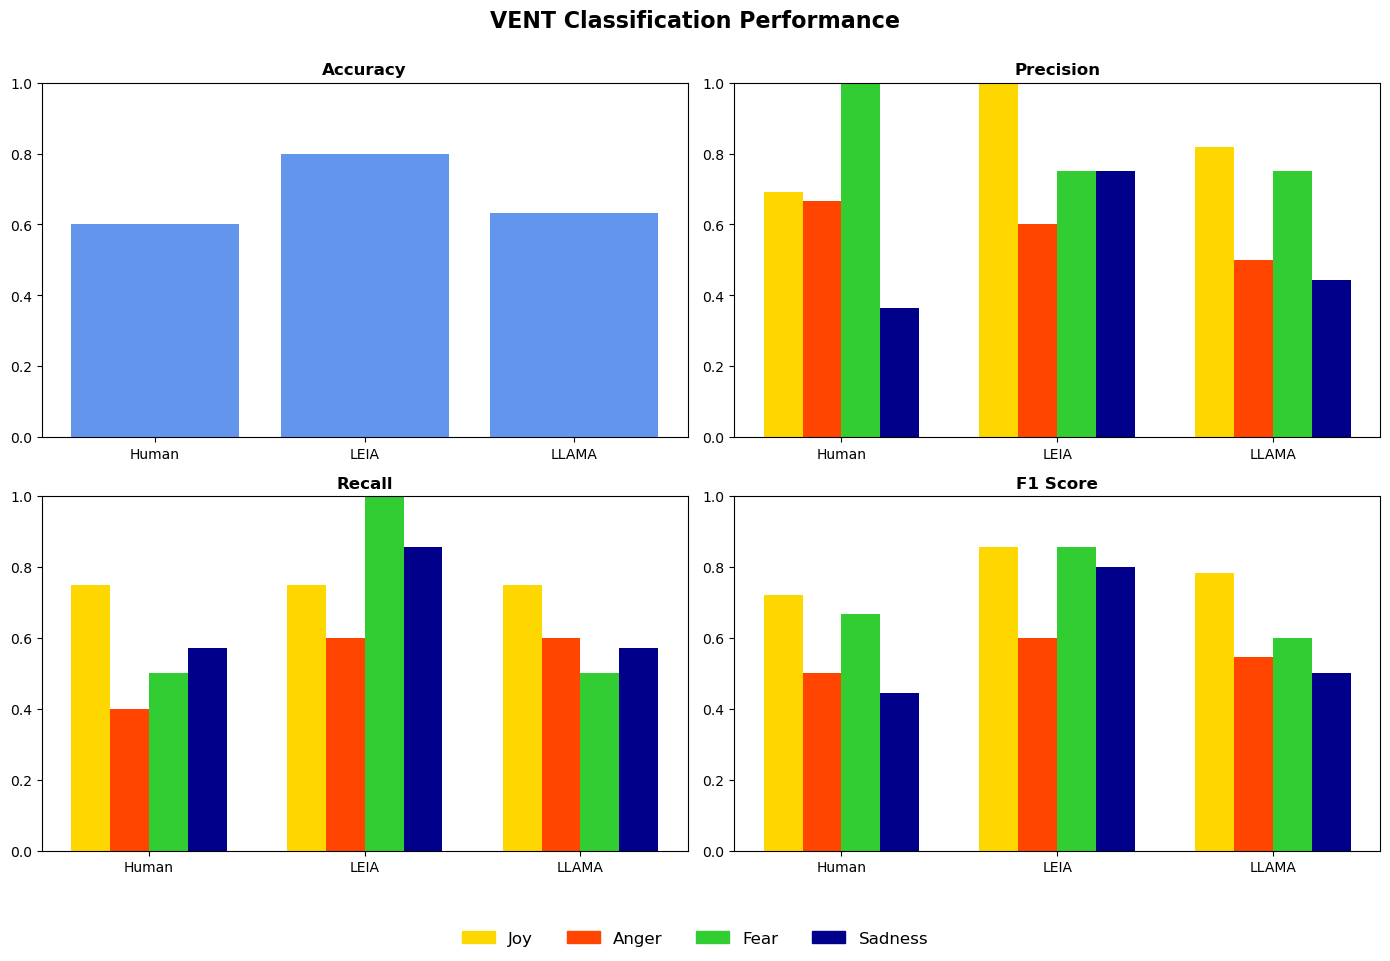

In [ ]:
# Visualization
plot_metrics_4_classes(
    title_prefix="VENT",
    accuracy=acc,
    precision_list=[prec_joy, prec_anger, prec_fear, prec_sadness],
    recall_list=[recall_joy, recall_anger, recall_fear, recall_sadness],
    f1_list=[f1_joy, f1_anger, f1_fear, f1_sadness],
    models=["Human", "LEIA", "LLAMA"]
)

### Evaluation: 

Among the three compared "classfiers", LEIA displays the best overall performance. However, as LEIA only reaches accuracy of 0.8, this is not due to its effective sentiment classification but more due to the relatively weak performances of human and LLAMA classification. Human classification is very volatile in precision and recall across all classes, with strong precision of classifying "Fear" and decent recall of the "Joy" class but only mediocre to weak classification performance in the other classes. This is also reflected in the F1-score. LEIA displays perfect precsion of "Joy" and perfect recall of "Fear" as well as strong recall of "Sadness". Consistent classification performances, exempting "Anger", are also reflected in LEIA's F1-scores. Llama performs decent classification of "Joy", it struggles however with providing sufficient precision/recall in the other classes. This is also reflected in its F1-score. 

Overall, while individual human classification failed to provide sufficient classification accuracy in this scenario, the majority vote seemed to be the "gold standard" of image classification. In respect to this benchmark, LEIA provides substantial classification accuracy and overall performance. LLMs such as Llama, in this case, struggle with providing sufficient accuracy. It almost seems to reflect human fallacies as classifications of the LLM and a human individual often align in the example. Thus, it might be insightful to create/test a composite classifier applying a LLM majority vote. This might be a path to further research.